终于有个能用的模型了...

Todo:
- 改进ROC
- 尝试每个epoch随机载入数据
- 尝试正则化 https://cloud.tencent.com/developer/ask/149180
- 特征工程 https://zhuanlan.zhihu.com/p/37880492
- weight scale
- 考虑样本不平衡 https://zhuanlan.zhihu.com/p/56882616

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
sys.path.append("..")
import autoaim

# Devices
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Device: GPU.')
else:
    device = torch.device('cpu')
    print('Device: CPU.')

device = torch.device('cpu')

# Dataset
def preprocess(t,h):
    # shuffling
    r = torch.randperm(t.size(0))
    t = t[r,:]
    # GIVE ME MORE!!
    _ = t[:,:-1]
    t = torch.cat((_,t[:,-1:]),1)
    return t

def load(filename):
    header, data = autoaim.helpers.read_csv(filename)
    data = torch.Tensor(data).to(device)
    data = preprocess(data,header)
    x = data[:, :-1]
    y = data[:, -1:]
    return x, y, header

x_train, y_train, header = load('test_pair_train.csv')
x_test, y_test, _ = load('test_pair_test.csv')

train_dataset_size = x_train.size(0)
test_dataset_size = x_test.size(0)
input_size = x_train.size(1)
output_size = 1

print('====== Input ======')
print('train_dataset_size: {}'.format(train_dataset_size))
print('test_dataset_size: {}'.format(test_dataset_size))
print('input_size: {}'.format(input_size))

# Model
class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        y_pred = self.sigmoid(self.linear(x))
        return y_pred

# Training loop
@autoaim.helpers.time_this
def train(learning_rate, epoch_num):
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    # Train loop
    print('====== Config ======')
    print('learning_rate: {}'.format(learning_rate))
    print('epoch_num: {}'.format(epoch_num))
    for epoch in range(epoch_num):
        # Forward pass
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == 0 or (epoch+1) % (epoch_num/10) == 0:
            y_pred = model(x_test)
            loss_test = criterion(y_pred, y_test)
            print("Epoch: [{!s:6}/{!s:6}], Loss: {:.2f}, Test loss: {:.2f}"
                  .format(epoch+1, epoch_num, loss,loss_test))

Device: CPU.
====== Input ======
train_dataset_size: 925
test_dataset_size: 243
input_size: 8
decorating


In [4]:
model = Model().to(device)
# train(0.00003, 100000)
train(0.01, 30000)


starting timer
====== Config ======
learning_rate: 0.01
epoch_num: 30000
Epoch: [1     /30000 ], Loss: 0.80, Test loss: 0.27
Epoch: [3000  /30000 ], Loss: -12.09, Test loss: -13.11
Epoch: [6000  /30000 ], Loss: -12.46, Test loss: -13.52
Epoch: [9000  /30000 ], Loss: -12.74, Test loss: -13.71
Epoch: [12000 /30000 ], Loss: -12.93, Test loss: -13.92
Epoch: [15000 /30000 ], Loss: -13.18, Test loss: -14.09
Epoch: [18000 /30000 ], Loss: -13.32, Test loss: -14.15
Epoch: [21000 /30000 ], Loss: -13.49, Test loss: -14.19
Epoch: [24000 /30000 ], Loss: -13.55, Test loss: -14.27
Epoch: [27000 /30000 ], Loss: -13.64, Test loss: -14.29
Epoch: [30000 /30000 ], Loss: -13.66, Test loss: -14.36
Elapsed Time = 0:00:09.229995


Data Distribution


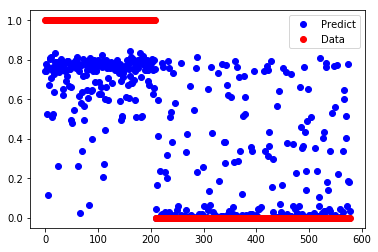

ROC
true positive: 195
false positive: 54
true negative: 315
false negative: 14

Weight


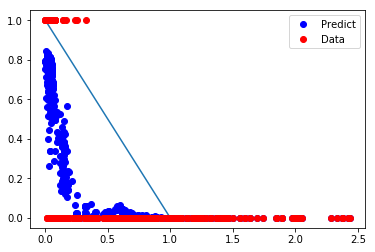

w[0] bounding_rect_ratio #1: -7.051994323730469


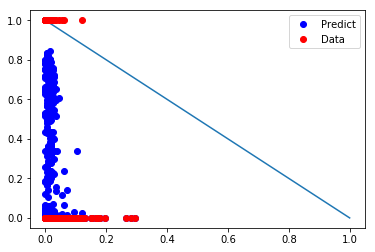

w[1] rotated_rect_angle #1: -0.3192584216594696


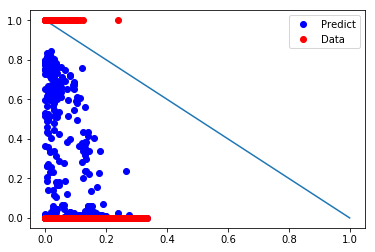

w[2] grayscale #1: -1.6331385374069214


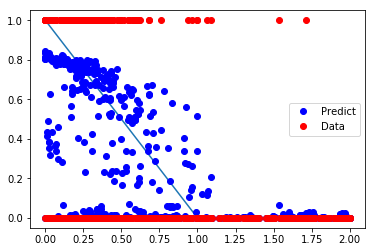

w[3] point_area #1: -1.2910574674606323


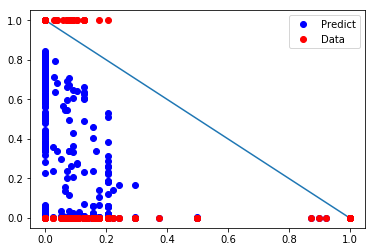

w[4] bounding_rect_ratio #2: -1.6208176612854004


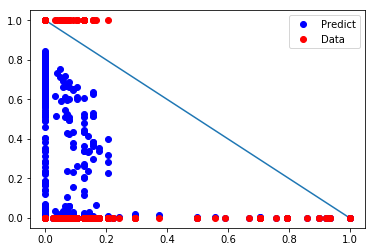

w[5] rotated_rect_angle #2: -1.891515851020813


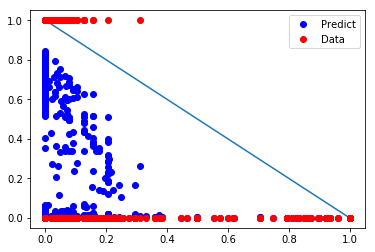

w[6] grayscale #2: -4.0366740226745605


In [34]:
# Test
def analyse(x_anls, y_anls, threshold):
    # Predict
    y_pred = model(x_anls)

    # Convert to numpy array
    x_anls, y_anls, y_pred = (t.numpy() for t in [x_anls, y_anls, y_pred])

    # Sort
    _1,_2 = np.where(y_anls==1)[0],np.where(y_anls==0)[0]
    x_anls, y_anls, y_pred = (np.concatenate((t[_1,:],t[_2,:])) for t in (x_anls, y_anls, y_pred))

    # Distribution
    print('Data Distribution')
    x = np.arange(0, x_anls.shape[0], dtype=int)
    # x_anls = np.arange(0, 40, dtype=int)
    plt.plot(x, y_pred[x,:], 'bo', label='Predict')
    plt.plot(x, y_anls[x,:], 'ro', label='Data')
    plt.legend()
    plt.show()

    # ROC
    print('ROC')
    num_positive = len(np.where(y_anls==1)[0])
    num_negative = len(np.where(y_anls==0)[0])
    _ = np.where(y_pred>=threshold)[0]
    num_true_positive = len(np.where(y_anls[_,:]==1)[0])
    num_false_positive = len(np.where(y_anls[_,:]==0)[0])
    _ = np.where(y_pred<threshold)[0]
    num_false_negative = len(np.where(y_anls[_,:]==1)[0])
    num_true_negative = len(np.where(y_anls[_,:]==0)[0])
    print('true positive: {}'.format(num_true_positive))
    print('false positive: {}'.format(num_false_positive))
    print('true negative: {}'.format(num_true_negative))
    print('false negative: {}\n'.format(num_false_negative))

    # Weight
    x = np.linspace(0,1)
    w = [wi.data.cpu() for wi in model.parameters()]
    w = torch.cat((w[0][0],w[1])).numpy()
    print('Weight')
    b = w[-1]
    for i in range(input_size):
        a = w[i]
        y = a*x+b
        plt.plot(x, (y-y.min())/(y.max()-y.min()), linestyle='-')
        plt.plot(x_anls[:, i], y_pred, 'bo', label='Predict')
        plt.plot(x_anls[:, i], y_anls, 'ro', label='Data')
        plt.legend()
        plt.show()
        _1, _2 = i%(len(header) - 1), int((i+1)/len(header)+1)
        print('w[{}] {} #{}: {}'.format(i, header[_1], _2, w[i]))
# Save     
def save(filename):
    dataloader = autoaim.DataLoader()
    autoaim.helpers.new_csv(filename, header[:-1])
    w = [wi.data.cpu() for wi in model.parameters()]
    w = torch.cat((w[0][0], w[1])).numpy()
    autoaim.helpers.append_csv(filename, w)
    

with torch.no_grad():
#     x_test, y_test,*_ = load('test.csv', 0)
    save('test11_weight_pair.csv')
    analyse(x_test, y_test, 0.5)
    

In [5]:
header[:-1]+['constant']

['bounding_rect_ratio',
 'rotated_rect_angle',
 'grayscale',
 'point_area',
 'constant']